In [332]:
from skimage import io, filters, feature
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage
from scipy import signal
import pandas as pd
import string
%matplotlib inline  

In [333]:
templates = []
directory = "templates\\"
for i in range(1, 6):
    filename = directory + "Pat" + str(i).zfill(2)+ ".bmp"
    image = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    templates.append(image.astype("int"))
templates = np.array(templates)

templates[2].shape

(90, 90)

(array([  0, 255]), array([2700, 5400], dtype=int64))

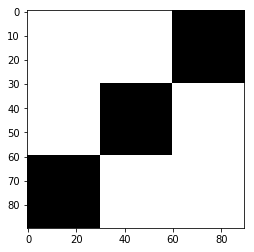

In [334]:
plt.imshow(templates[2], cmap = "gray")
np.unique(templates[2], return_counts = True)

In [335]:
images = []
directory = "images\\"
for i in range(1,21):
    filename = directory + "Pic" + str(i).zfill(2)+ ".bmp"
    image = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    #image = cv.medianBlur(image, 3)
    _, image = cv.threshold(image, 128,255, cv.THRESH_BINARY)
    images.append(image.astype("int"))
    
images = np.array(images)
images.shape

(20, 150, 150)

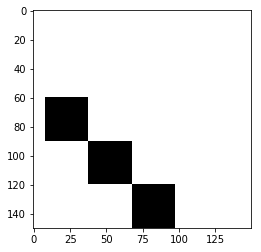

In [338]:
plt.imshow(images[18], cmap = "gray")


In [339]:
def match_slow(I, t):
    H, W = I.shape
    h, w = t.shape
    best_index = [0,0]
    best_val = np.inf
    for i in range(H - h + 1):
        for j in range(W - w + 1):
            batch = I[i:i + h, j:j + w]
            cor = np.linalg.norm(batch - t)
            if cor < best_val:
                best_val = cor
                best_index = [i, j]
    return best_index, best_val

        

In [340]:
import time

match_indexes = np.zeros((20, 5, 2))
scores = np.zeros((20, 5))
start_time = time.time()
for i, image in enumerate(images):
    for t, template in enumerate(templates):
        index, score = match_slow(image, template)
        match_indexes[i, t] = index
        scores[i, t] = score
        print(i, t)
print(time.time() - start_time, " seconds")

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4
8 0
8 1
8 2
8 3
8 4
9 0
9 1
9 2
9 3
9 4
10 0
10 1
10 2
10 3
10 4
11 0
11 1
11 2
11 3
11 4
12 0
12 1
12 2
12 3
12 4
13 0
13 1
13 2
13 3
13 4
14 0
14 1
14 2
14 3
14 4
15 0
15 1
15 2
15 3
15 4
16 0
16 1
16 2
16 3
16 4
17 0
17 1
17 2
17 3
17 4
18 0
18 1
18 2
18 3
18 4
19 0
19 1
19 2
19 3
19 4
13.734108448028564  seconds


In [343]:
res = np.zeros((20, 3), dtype="int")

res[:,0] = np.argmin(scores, axis=1).astype("int") + 1
for i in range(20):
    res[i, 1:] = match_indexes[i, res[:,0][i] - 1]
df = pd.DataFrame(res, columns = ["template #", "y", "x"])
display(df)

,template #,y,x
0,5,55,7
1,4,29,49
2,4,53,102
3,1,106,60
4,4,48,43
5,2,54,51
6,1,106,14
7,3,41,22
8,3,43,17
9,2,27,34


In [344]:
def match_fast(I, t):
    H, W = I.shape
    I_f = np.fft.fft2(I)
    t_f = np.conj(np.fft.fft2(t, I.shape))
    c = np.real(np.fft.ifft2((I_f * t_f) / (np.abs((I_f * t_f) + 1e-7))))
    return c.max(), np.argwhere(c == c.max())[0]


In [345]:
for i in range(20):
    images[i][images[i] == 0] = -1
    images[i][images[i] == 255] = 1

for i in range(5):
    templates[i][templates[i] == 0] = -1
    templates[i][templates[i] == 255] = 1

In [346]:
import time
match_indexes = np.zeros((20, 5, 2))
scores = np.zeros((20, 5))
start_time = time.time()
for i, image in enumerate(images):
    for t, template in enumerate(templates):
        score, index = match_fast(image, template)
        match_indexes[i, t] = index
        scores[i, t] = score
print(time.time() - start_time, " seconds")

0.24451613426208496  seconds


As you can see by using phase correlation the running time got nearly 50 times faster

In [347]:
res = np.zeros((20, 3), dtype="int")

res[:,0] = np.argmax(scores, axis=1).astype("int") + 1
for i in range(20):
    res[i, 1:] = match_indexes[i, res[:,0][i] - 1]
df = pd.DataFrame(res, columns = ["template #", "y", "x"])
display(df)

,template #,y,x
0,5,55,7
1,4,29,49
2,4,53,102
3,1,106,60
4,4,48,43
5,2,54,51
6,1,106,14
7,3,41,22
8,3,43,17
9,2,27,34
